# Preparation des données
### Initialisation du projet

In [10]:
# imports
import numpy as np
import os

from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(420) 

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# où sauver les figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "projet"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img") # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


### Importation

In [11]:
import os
import pandas as pd

DATASETS_PATH = os.path.join(".\datasets")

def load_datasets_data(dataset_path=DATASETS_PATH):
	csv_general = pd.read_csv(os.path.join(dataset_path, "general_data.csv"))
	csv_manager = pd.read_csv(os.path.join(dataset_path, "manager_survey_data.csv"))
	csv_employee = pd.read_csv(os.path.join(dataset_path, "employee_survey_data.csv"))
	csv_intime = pd.read_csv(os.path.join(dataset_path, "in_time.csv"))
	csv_outtime = pd.read_csv(os.path.join(dataset_path, "out_time.csv"))
	return csv_general, csv_manager, csv_employee, csv_intime, csv_outtime

In [12]:
general_set, manager_set, employee_set, intime_set, outtime_set = load_datasets_data()

In [13]:
dataset_merge = general_set.merge(employee_set.merge(manager_set, on="EmployeeID"), on="EmployeeID")
dataset = dataset_merge.copy()

On sépare le code ici car il se bloque si éxécuté en un seul bloc.

### Fusion des données horaire avec le dataset

On importe les données horaires et on les traite puis fusionne avec le dataset complet (general, manager et employés).

In [14]:
#Remplacement des variables NaN en 0
intime_set = intime_set.replace(np.nan, 0)
outtime_set = outtime_set.replace(np.nan, 0)

#Selectione et transformation en format date de la librairie pandas
intime_set.iloc[:, 1:] = intime_set.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')
outtime_set.iloc[:, 1:] = outtime_set.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')

#On fusionne les deux tableaux (entrée et sortie)
intime_set = intime_set.append(outtime_set)


#On calcule la difference entre l'heure d'entrée et de sortie
intime_set = intime_set.diff(periods=4410)
intime_set = intime_set.iloc[4410:]
intime_set.reset_index(inplace=True)

intime_set.drop(columns=['index', 'Unnamed: 0'],axis=1, inplace=True)
intime_set.drop(['2015-01-01', '2015-01-14','2015-01-26','2015-03-05',
             '2015-05-01','2015-07-17','2015-09-17','2015-10-02',
              '2015-11-09','2015-11-10','2015-11-11','2015-12-25'
             ], axis = 1,inplace=True)

intime_set['Actual Time']=intime_set.mean(axis=1)
intime_set['hrs']=intime_set['Actual Time']/np.timedelta64(1,'h')

C:\Users\cruel\AppData\Local\Temp/ipykernel_18968/390643016.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  intime_set.reset_index(inplace=True)


In [15]:
intime_set['hrs']=intime_set['Actual Time']/np.timedelta64(1,'h')
intime_set.reset_index(inplace=True)

# Creation des attributs index et hours (hrs)
intime_set.drop(intime_set.columns.difference(['index','hrs']), 1, inplace=True)
intime_set.rename(columns={'index': 'EmployeeID'}, inplace=True)

#On fusionne notre tableau d'heures avec le dataset global
dataset = dataset.merge(intime_set, on="EmployeeID")

C:\Users\cruel\AppData\Local\Temp/ipykernel_18968/3378375524.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  intime_set.drop(intime_set.columns.difference(['index','hrs']), 1, inplace=True)


### ANOVA / KHI2

Le Khi2 (ou Chi2 en anglais et sur python) permet d'avoir une idée des dépendances des variables par rapport à l'attrition.

In [16]:
# KHI2 
import scipy.stats as stats

for name_column in dataset.select_dtypes(include=['object']).columns:
    if (name_column != "Attrition"):
        matrice = pd.crosstab(dataset['Attrition'], dataset[name_column])
        chi2, pvalue,dof, expected = stats.chi2_contingency(matrice)
        print(name_column, "= Statistics : ", chi2, ", p_value : ", pvalue, \
			"\033[32mDépendant\033[0m" if pvalue < 0.05 else "\033[31mIndépendant\033[0m")

BusinessTravel = Statistics :  72.50717871985921 , p_value :  1.7999738337215978e-16 Dépendant
Department = Statistics :  29.075324276447617 , p_value :  4.857060952676939e-07 Dépendant
EducationField = Statistics :  46.18754168561295 , p_value :  8.317648156384632e-09 Dépendant
Gender = Statistics :  1.3624186737962352 , p_value :  0.24311874379456289 Indépendant
JobRole = Statistics :  25.114161989733258 , p_value :  0.00148679389520896 Dépendant
MaritalStatus = Statistics :  138.34881335193026 , p_value :  9.076886223293833e-31 Dépendant
Over18 = Statistics :  0.0 , p_value :  1.0 Indépendant


ANOVA suit le même principe que Khi2 mais calcule différemment.

In [17]:
#ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

for name_column in dataset.select_dtypes(include=np.number).columns:
    test_anova = name_column + ' ~ Attrition'
    model = ols(test_anova, data=dataset).fit()
    result_anova = sm.stats.anova_lm(model, typ=2)
    print(name_column, "= F : ", result_anova["F"][0], ", p_value : ", result_anova["PR(>F)"][0], \
		 "\033[32mDépendant\033[0m" if result_anova["PR(>F)"][0] < 0.05 else "\033[31mIndépendant\033[0m")

Age = F :  114.5643529785229 , p_value :  2.0643297829987788e-26 Dépendant
DistanceFromHome = F :  0.3982188593045006 , p_value :  0.5280432738303005 Indépendant
Education = F :  1.0054756822239606 , p_value :  0.3160442234628276 Indépendant
EmployeeCount = F :  1.3085251056897262 , p_value :  0.2527239956032555 Indépendant
EmployeeID = F :  0.09158223883824057 , p_value :  0.7621895039193467 Indépendant
JobLevel = F :  0.46719676421724343 , p_value :  0.494315556720321 Indépendant
MonthlyIncome = F :  4.293854455865298 , p_value :  0.03830837896884729 Dépendant
NumCompaniesWorked = F :  7.844753196464558 , p_value :  0.0051191555746321225 Dépendant
PercentSalaryHike = F :  4.645159524851074 , p_value :  0.031195233418440483 Dépendant
StandardHours = F :  1.3085251056897262 , p_value :  0.2527239956032555 Indépendant
StockOptionLevel = F :  0.2118003400451248 , p_value :  0.6453826659212034 Indépendant
TotalWorkingYears = F :  131.45193284103956 , p_value :  5.241246810654903e-30 Dépen

In [18]:
dataset.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,hrs
count,4409.000000,4409.000000,4409.000000,4409.0,4409.000000,4409.000000,4409.000000,4390.000000,4409.000000,4409.0,...,4409.000000,4409.000000,4409.000000,4409.000000,4384.000000,4389.000000,4372.000000,4409.000000,4409.000000,4409.000000
mean,36.923112,9.188251,2.912905,1.0,2205.000000,2.063960,65031.660240,2.695444,15.210252,8.0,...,2.798594,7.004990,2.187571,4.122023,2.723996,2.728184,2.761436,2.729644,3.153776,7.314463
std,9.134220,8.100992,1.024048,0.0,1272.912998,1.106814,47073.969139,2.498840,3.659203,0.0,...,1.288222,6.122203,3.222042,3.566975,1.092571,1.101371,0.706245,0.711223,0.360775,1.330903
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,5.416880
25%,30.000000,2.000000,2.000000,1.0,1103.000000,1.000000,29110.000000,1.000000,12.000000,8.0,...,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,6.278995
50%,36.000000,7.000000,3.000000,1.0,2205.000000,2.000000,49080.000000,2.000000,14.000000,8.0,...,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,7.011237
75%,43.000000,14.000000,4.000000,1.0,3307.000000,3.000000,83800.000000,4.000000,18.000000,8.0,...,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000,7.900932
max,60.000000,29.000000,5.000000,1.0,4409.000000,5.000000,199990.000000,9.000000,25.000000,8.0,...,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.937261


## Pipeline	

selection attrition vers y

In [19]:
Attrition = dataset.loc[:, "Attrition"]

In [20]:
dataset_pl = dataset.copy()

useless_value = ['Attrition','StandardHours','EmployeeCount','EmployeeID', "Over18", "Department"] 
dataset_pl = dataset_pl.drop(useless_value, axis=1)

ds_num = dataset_pl.select_dtypes(include=[np.number])
ds_num.drop('JobLevel', axis=1, inplace=True)

ds_str = dataset_pl.select_dtypes(exclude=[np.number])
ds_str["JobLevel"] = dataset_pl["JobLevel"] 

D:\Program Files (x86)\Anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\cruel\AppData\Local\Temp/ipykernel_18968/4174448821.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_str["JobLevel"] = dataset_pl["JobLevel"]


In [21]:
num_attribs = list(ds_num)
str_attribs = list(ds_str)

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(ds_str)

num_pipeline = Pipeline([
	('imputer', SimpleImputer(strategy="median")), 
	('std_scaler', StandardScaler()),			   
])

pipeline = ColumnTransformer([
	("str_vars", encoder, str_attribs),
	("num_vars", num_pipeline, num_attribs)
])

dataset_pipeline = pipeline.fit_transform(dataset_pl, Attrition)
dataset_pipeline

array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         3.80171475e-01, -4.26287131e-01,  1.13261739e-03],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
        -1.02601647e+00,  2.34583671e+00, -3.74511693e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         3.80171475e-01, -4.26287131e-01, -3.94700539e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -1.02601647e+00, -4.26287131e-01, -1.23942994e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         3.80171475e-01,  2.34583671e+00,  1.40758587e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -1.02601647e+00, -4.26287131e-01, -6.03172187e-01]])

In [23]:
dataset_prepared = pd.DataFrame(
    dataset_pipeline,
    columns=list(np.concatenate((num_attribs, encoder.get_feature_names(str_attribs))))
)

In [24]:
dataset_prepared.describe()

,Age,DistanceFromHome,Education,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,...,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,JobLevel_1,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5
count,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,...,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03,4.409000e+03
mean,0.102064,0.188478,0.709458,0.018372,0.412338,0.108188,0.315491,0.055795,0.089816,0.400091,...,-2.963784e-17,5.397512e-17,-1.938924e-17,1.923816e-17,-6.899549e-17,4.231891e-16,2.761582e-16,-1.299835e-16,7.581446e-16,-2.024539e-16
std,0.302767,0.391138,0.454064,0.134306,0.492311,0.310653,0.464764,0.229551,0.285951,0.489972,...,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.172692e+00,-1.144324e+00,-6.790164e-01,-1.155739e+00,-1.583750e+00,-1.573776e+00,-2.506551e+00,-2.432204e+00,-4.262871e-01,-1.425948e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.199895e-01,-6.542488e-01,-6.790164e-01,-5.949758e-01,-6.659326e-01,-6.637722e-01,-1.085151e+00,-1.026016e+00,-4.262871e-01,-7.781075e-01
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.563620e-01,-3.275320e-01,-3.686190e-01,-3.145944e-01,2.518845e-01,2.462314e-01,3.362485e-01,3.801715e-01,-4.262871e-01,-2.278607e-01
75%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,1.563620e-01,3.259017e-01,2.521759e-01,8.069312e-01,1.169702e+00,1.156235e+00,3.362485e-01,3.801715e-01,-4.262871e-01,4.407042e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.485416e+00,5.390013e+00,3.976945e+00,3.610745e+00,1.169702e+00,1.156235e+00,1.757648e+00,1.786359e+00,2.345837e+00,2.722368e+00


### Definition de x et y

Définition de notre colonne attrition qui est notre colonne dépendante (y) avec la convertion des Non en 0 et le Oui en 1 et le reste de notre dataset sont des colonnes indépendantes (x)

In [25]:
y = pd.get_dummies(Attrition, drop_first=True)
x = dataset_prepared

# Regression Logistique

### Séparation du dataset en données de test et d'apprentissage

Afin d'avoir un modèle avec de bonnes performances, il nous faut l'entrainer avec y_train et x_train pour trouver la pondération ou les coefficients optimaux, après cela on test son apprentissage avec x_test et y_test.

Le ratio test/train et definit 70% pour l'apprentissage et a 30% pour le test, car il faut au modèle une plus grande proporstion des données pour qu'il s'habitue aux données, de plus nous fesons une stratification sur y qui est la colonne attrition pour avoir la proportion de oui est de non.

In [26]:
from sklearn.model_selection import train_test_split
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(x, y, train_size=0.7, test_size=0.3, stratify=y)

On applique les paramètres trouvés par GridSearch _(voir notebook ProjetIA - RegLog)_ à la regression logistique.

### Implementation du modèle

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

#"newton-cg", "lbfgs", "liblinear", "sag", "saga"
lr = LogisticRegression(C=0.3, max_iter=300, solver='newton-cg')
lr.fit(X_train_lr,y_train_lr.values.ravel())

y_pred_lr = lr.predict(X_test_lr)
y_pred_prob_lr = lr.predict_proba(X_test_lr)

# Support Vector Classifier (SVC)

### Creation des sets d'entrainement et de test

In [28]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=100)
from sklearn.model_selection import train_test_split
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(x, y, train_size=0.7, test_size=0.3, stratify=y)

### Implémentation du model : SVC

In [29]:
#Import svm model
from sklearn import svm
from sklearn import metrics

#Create a svm Classifier
clf_svc = svm.SVC(kernel='rbf', probability=True) # Linear Kernel

#Train the model using the training sets
clf_svc.fit(X_train_svc, y_train_svc)

#Predict the response for test dataset
y_pred_svc = clf_svc.predict(X_test_svc)
y_pred_prob_svc=clf_svc.predict_proba(X_test_svc)

print("Accuracy:",metrics.accuracy_score(y_test_svc, y_pred_svc))

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 0.8972033257747544


# Decision Tree

### Creation des sets d'entrainement et de test

In [30]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=100)
from sklearn.model_selection import train_test_split
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(x, y, train_size=0.7, test_size=0.3, stratify=y)

### Implémentation du model : Arbre de décision

In [31]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# Create Decision Tree classifer object
clf_dt = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf_dt = clf_dt.fit(X_train_dt,y_train_dt)

#Predict the response for test dataset
y_pred_dt = clf_dt.predict(X_test_dt)
y_pred_prob_dt=clf_dt.predict_proba(X_test_dt)

print("Accuracy:",metrics.accuracy_score(y_test_dt, y_pred_dt))

Accuracy: 0.9599395313681028


#### Entrainement du modèle

In [32]:
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(max_depth = 10, random_state = 0)
clf_dt.fit(X_train_dt, y_train_dt)
clf_dt.predict(X_test_dt)

array([0, 1, 0, ..., 0, 0, 0], dtype=uint8)

#### Premier essai de visualisation de l'arbre

[Text(808.228125, 1660.4509090909091, 'JobRole_Research Scientist <= -1.129\ngini = 0.271\nsamples = 3086\nvalue = [2588, 498]'),
 Text(319.85357142857146, 1502.3127272727272, 'DistanceFromHome <= 0.5\ngini = 0.495\nsamples = 260\nvalue = [143, 117]'),
 Text(241.1357142857143, 1344.1745454545455, 'EducationField_Technical Degree <= 0.5\ngini = 0.475\nsamples = 217\nvalue = [133, 84]'),
 Text(225.19285714285715, 1186.0363636363636, 'EducationField_Life Sciences <= 0.5\ngini = 0.461\nsamples = 208\nvalue = [133, 75]'),
 Text(131.52857142857144, 1027.898181818182, 'JobRole_Laboratory Technician <= -0.459\ngini = 0.332\nsamples = 95\nvalue = [75, 20]'),
 Text(87.68571428571428, 869.76, 'JobLevel_5 <= -1.234\ngini = 0.482\nsamples = 42\nvalue = [25, 17]'),
 Text(71.74285714285715, 711.6218181818183, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(103.62857142857143, 711.6218181818183, 'JobRole_Healthcare Representative <= -0.208\ngini = 0.45\nsamples = 38\nvalue = [25, 13]'),
 Text(63.771

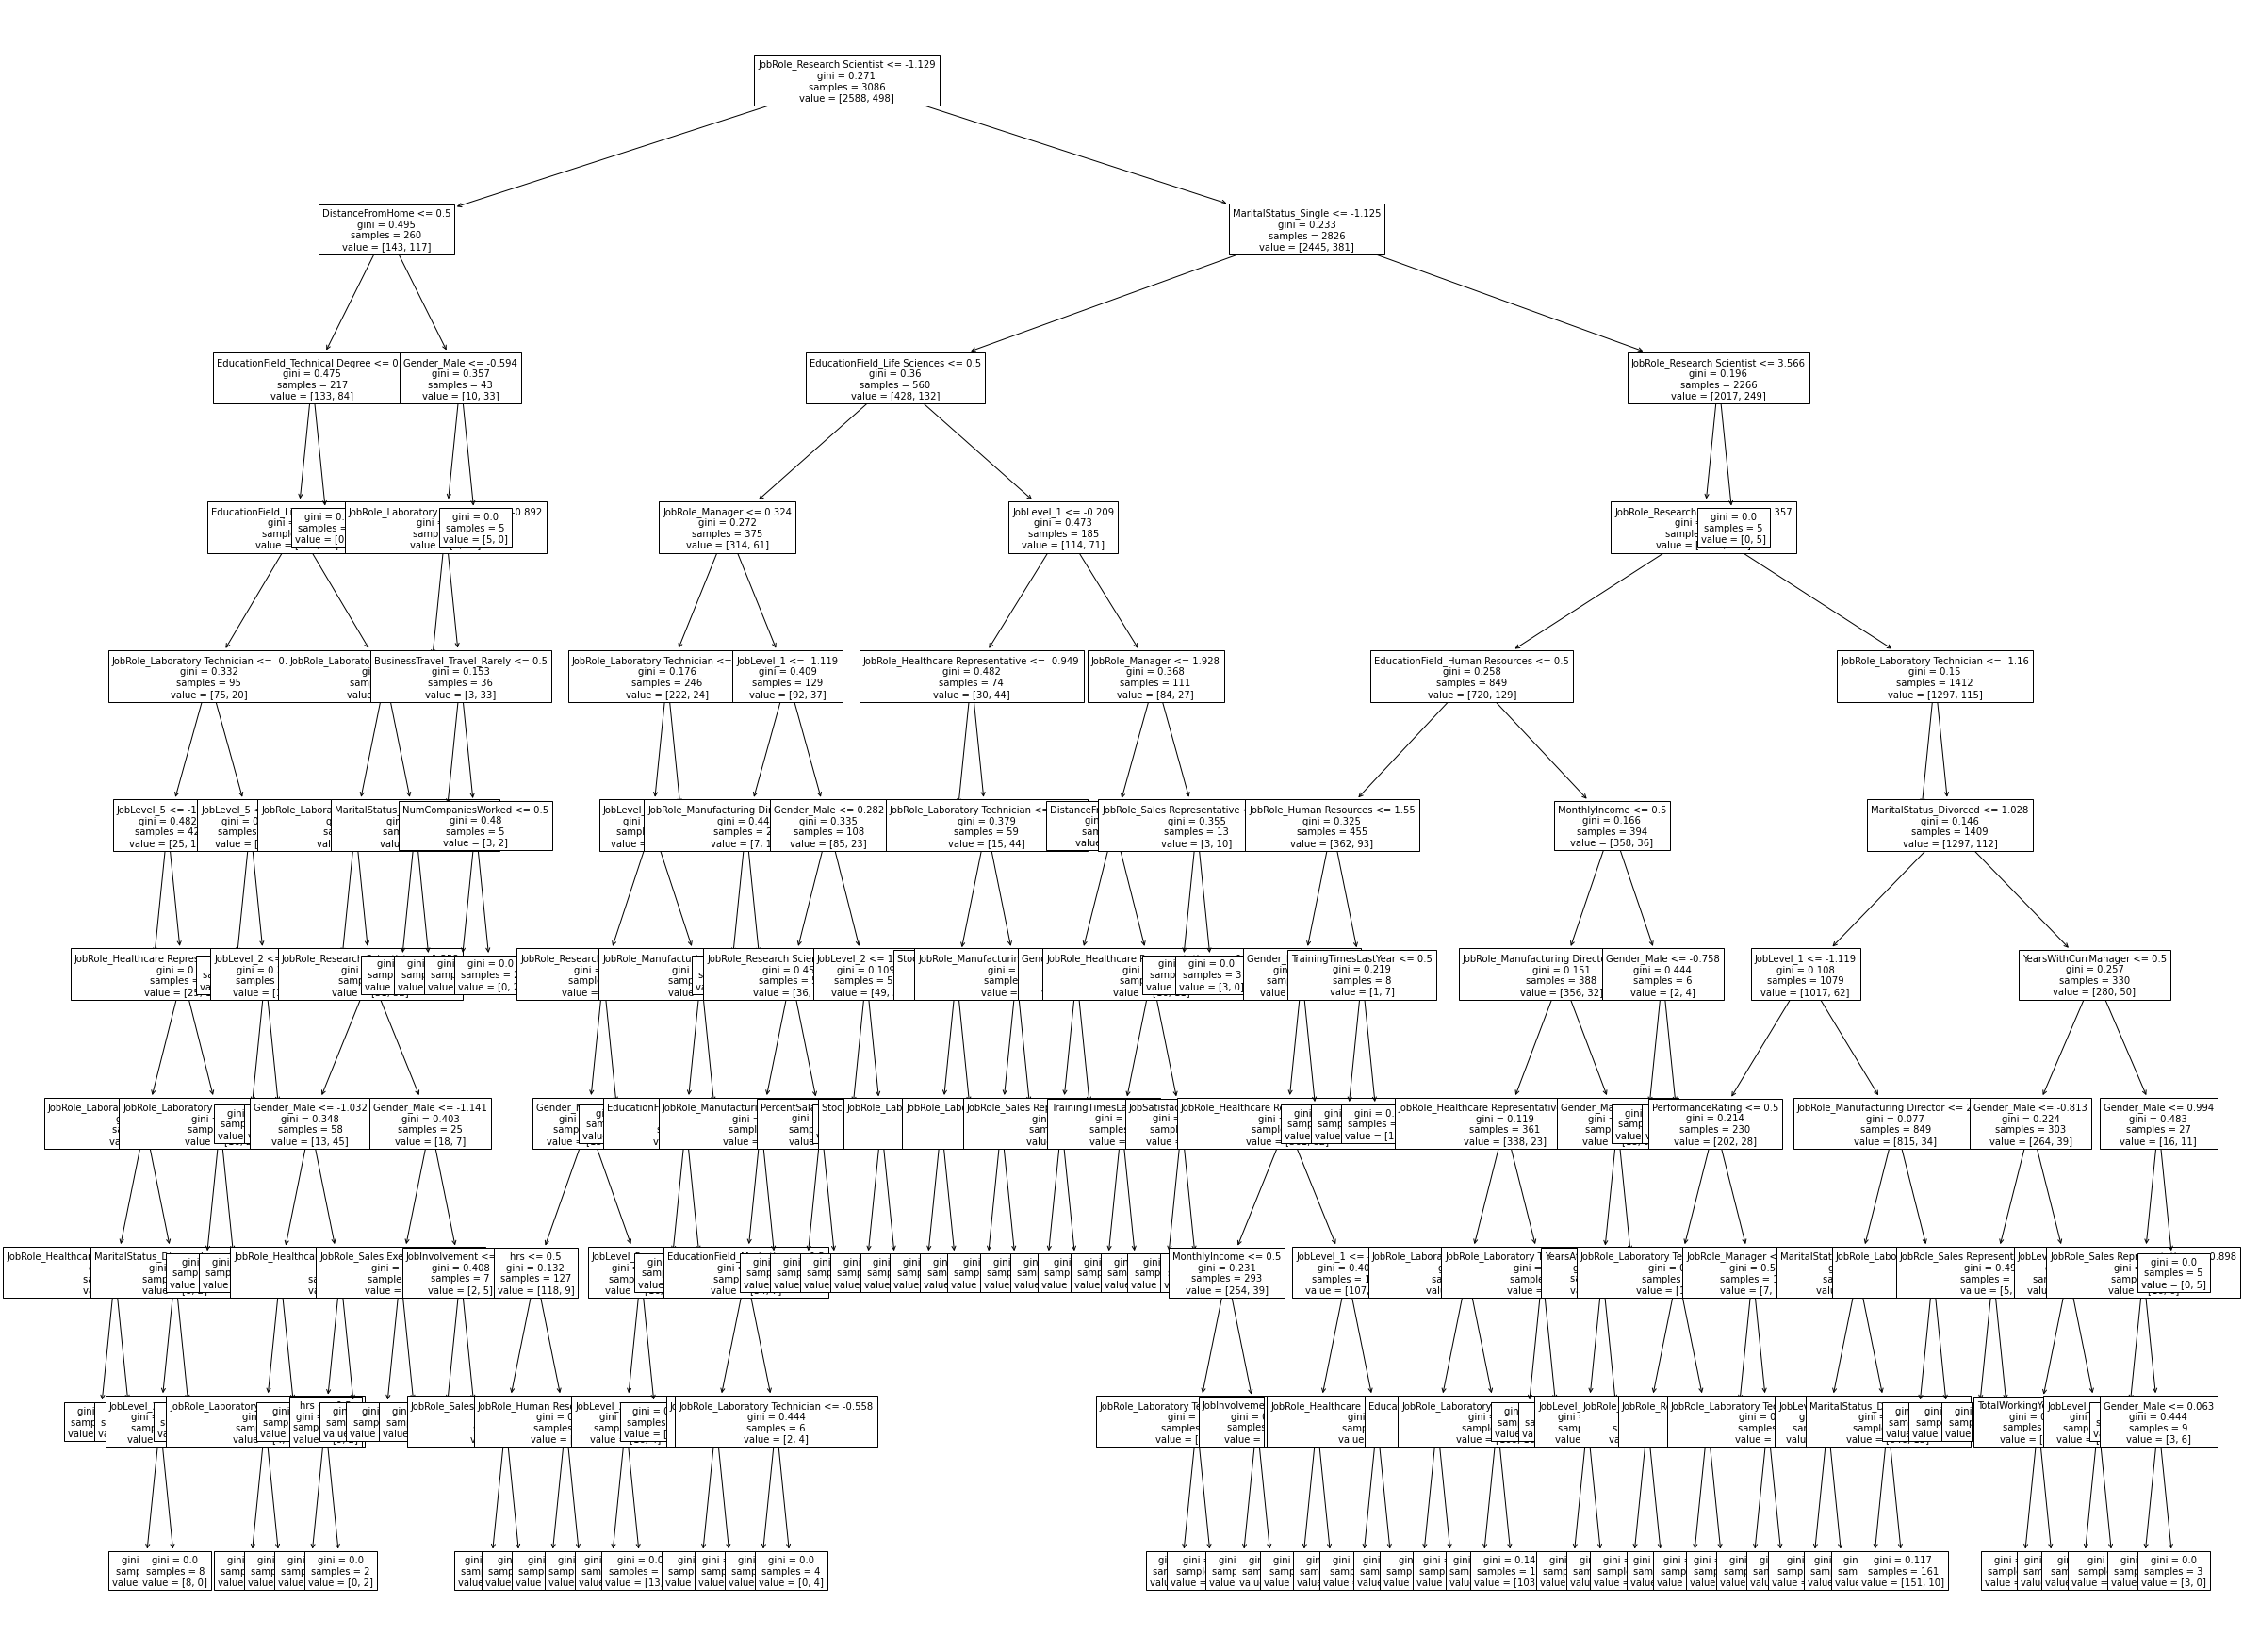

In [33]:
from sklearn import tree
plt.figure(figsize=(40,32))
tree.plot_tree(clf_dt, feature_names= X_test_dt.columns,fontsize=10)

Visualisation du graphique avec la librairie GraphViz

In [34]:
tree.export_graphviz(clf_dt,
                    out_file="tree.dot",
                    feature_names = X_test_dt.columns, 
                    class_names="Attrition",
                    filled = True)

In [35]:
!dot -Tpng tree.dot -o tree.png


'dot' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


# Random Forest

### Creation des sets d'entrainement et de test

In [36]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=100)
from sklearn.model_selection import train_test_split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(x, y, train_size=0.7, test_size=0.3, stratify=y)

### Implémentation du model : Random Forest

Entrainement du modèle

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Create a Gaussian Classifier
clf_rf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_rf.fit(X_train_rf,y_train_rf)

# prediction on test set
y_pred_rf=clf_rf.predict(X_test_rf)
y_pred_prob_rf=clf_rf.predict_proba(X_test_rf)

print("Accuracy:",metrics.accuracy_score(y_test_rf, y_pred_rf))


C:\Users\cruel\AppData\Local\Temp/ipykernel_18968/1508834012.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_rf.fit(X_train_rf,y_train_rf)


Accuracy: 0.9886621315192744


#### Hiérarchisation des features

In [38]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                        oob_score=False, random_state=None, verbose=0,
                        warm_start=False)

RandomForestClassifier(n_jobs=1)

# Performance et validation

In [39]:
y_pred_prob_rf = clf_rf.predict_proba(X_test_rf)
y_pred_prob_svc = clf_svc.predict_proba(X_test_svc)
y_pred_prob_lr = lr.predict_proba(X_test_lr)
y_pred_prob_dt = clf_dt.predict_proba(X_test_dt)

In [40]:
from sklearn import metrics

#Regression Logistique
pp_lr = y_pred_prob_lr[:,1]
fpr_lr, tpr_lr, threshold_lr = metrics.roc_curve(y_test_lr, pp_lr )
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)

#SVC
pp_svc = y_pred_prob_svc[:,1]
fpr_svc, tpr_svc, threshold_svc = metrics.roc_curve(y_test_svc, pp_svc )
roc_auc_svc = metrics.auc(fpr_svc, tpr_svc)

#Decision Tree
pp_dt = y_pred_prob_dt[:,1]
fpr_dt, tpr_dt, threshold_dt = metrics.roc_curve(y_test_dt, pp_dt )
roc_auc_dt = metrics.auc(fpr_dt, tpr_dt)

#Random Forest
pp_rf = y_pred_prob_rf[:,1]
fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(y_test_rf, pp_rf )
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)


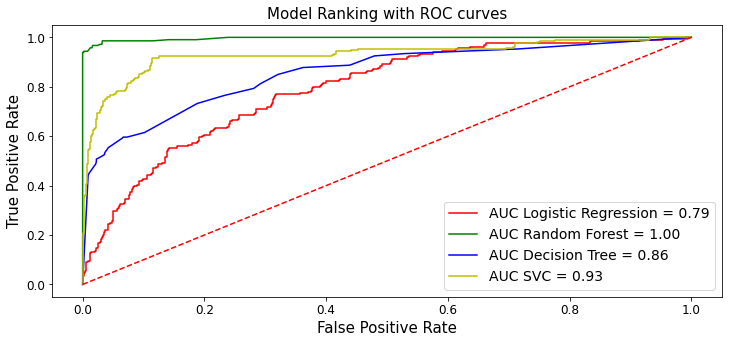

In [41]:
plt.figure(figsize=(12,5))
plt.plot(fpr_lr, tpr_lr, 'r', label = 'AUC Logistic Regression = %0.2f' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, 'g', label = 'AUC Random Forest = %0.2f' % roc_auc_rf)
plt.plot(fpr_dt, tpr_dt, 'b', label = 'AUC Decision Tree = %0.2f' % roc_auc_dt)
plt.plot(fpr_svc, tpr_svc, 'y', label = 'AUC SVC = %0.2f' % roc_auc_svc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('Model Ranking with ROC curves', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 14})

plt.show()

In [44]:
def predAttrition(name, model):
	countLeave = 0
	countStay = 0
	for i in range(len(dataset)):
		row = dataset_prepared.iloc[[i]]
		rowdf = pd.DataFrame(
			row,
			columns=list(np.concatenate((num_attribs, encoder.get_feature_names(str_attribs))))
			)
		pred = model.predict(rowdf)
		if pred == [1]:
			countLeave = countLeave + 1
		else:
			countStay = countStay + 1
	print("Will probably leave, with model", name, " : ", countLeave, "| {:.2%}".format(countLeave/len(dataset)))
	print("Will probably stay, with model", name, " : ", countStay, "| {:.2%}".format(countStay/len(dataset)))
	print('\n')
	return pred


predAttrition("logistic regression", lr)
predAttrition("SVC", clf_svc)
predAttrition("decision tree", clf_dt)
predAttrition("random forest", clf_rf)



Will probably leave, with model logistic regression  :  156 | 3.54%
Will probably stay, with model logistic regression  :  4253 | 96.46%


Will probably leave, with model SVC  :  415 | 9.41%
Will probably stay, with model SVC  :  3994 | 90.59%


Will probably leave, with model decision tree  :  500 | 11.34%
Will probably stay, with model decision tree  :  3909 | 88.66%


Will probably leave, with model random forest  :  700 | 15.88%
Will probably stay, with model random forest  :  3709 | 84.12%




array([0], dtype=uint8)